# Example database queries

We start with the database that is also on S3

In [1]:
from IPython.display import display
import duckdb
import pandas as pd
from pathlib import Path
# This database is stored on S3 also and gets updated whenever a batch of samples is processed
db_path = '/mnt/data3/master.duckdb'

# See what tables are in the database

In [2]:
def display_tables(duckdb_path):
    if not Path(duckdb_path).exists():
        raise FileNotFoundError(f'{duckdb_path} does not exist')
    with duckdb.connect(duckdb_path) as conn:
        db = conn.execute("PRAGMA show_tables;").fetchdf()
        tables = db['name'].tolist()

        for table in tables:
            print(f"First 3 rows of {table}:")
            df = conn.execute(f"SELECT * FROM {table}").fetchdf()
            print(f'{table} has {df.shape[0]} rows and {df.shape[1]} columns')
            display(df.head(3))

display_tables(db_path)

First 3 rows of annotations:
annotations has 2049722 rows and 10 columns


,seqhash_id,seed_ortholog,evalue,score,eggnog_ogs,max_annot_lvl,cog_category,description,preferred_name,sample_id
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,35725.K2S4S9,6.920000e-44,151.0,"2E6RZ@1|root,2SDEQ@2759|Eukaryota,3A5VV@33154|...",4751|Fungi,S,Spc19,SPC19,SRR19034773
1,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,40384.G7X951,1.480000e-30,119.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,-,SRR19034773
2,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,199306.XP_003068400.1,5.610000e-49,165.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,DFG10,SRR19034773


First 3 rows of cluster_members:
cluster_members has 2489980 rows and 2 columns


,seqhash_id,cluster_id
0,v1_DLS_54c838c1032a3d068567582a16f6c13e1738437...,v1_DLS_54c838c1032a3d068567582a16f6c13e1738437...
1,v1_DLS_755d8cd81f092ede2ffafab06277a3eda852647...,v1_DLS_54c838c1032a3d068567582a16f6c13e1738437...
2,v1_DLS_9a47c741434bbcd22d2056607e96c4529ff0fdc...,v1_DLS_54c838c1032a3d068567582a16f6c13e1738437...


First 3 rows of clusters:
clusters has 433785 rows and 3 columns


,cluster_id,representative_seqhash_id,size
0,v1_DLS_19696ccb77b302cd0cdff9203ea61ab6436f11d...,v1_DLS_19696ccb77b302cd0cdff9203ea61ab6436f11d...,2
1,v1_DLS_2c0cc78a9c59c1336b74f30e780f495a69dee48...,v1_DLS_2c0cc78a9c59c1336b74f30e780f495a69dee48...,1
2,v1_DLS_316ca6de3b5bd0f7e62f5c2b991f46a7b39c174...,v1_DLS_316ca6de3b5bd0f7e62f5c2b991f46a7b39c174...,3


First 3 rows of ec_numbers:
ec_numbers has 571387 rows and 2 columns


,seqhash_id,ec_number
0,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,1.3.1.94
1,v1_DLS_000ec45f128b07191f81108831b53bf12a4f6f5...,2.3.1.26
2,v1_DLS_0037284d637b1119a610281885e9fbdb987b20e...,6.2.1.45


First 3 rows of go_terms:
go_terms has 74845016 rows and 2 columns


,seqhash_id,go_term
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0007059
1,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0043232
2,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0044464


First 3 rows of kegg_info:
kegg_info has 0 rows and 6 columns


,seqhash_id,kegg_ko,kegg_pathway,kegg_module,kegg_reaction,kegg_rclass


First 3 rows of schema_version:
schema_version has 0 rows and 3 columns


,version,migration_name,applied_at


First 3 rows of sequences:
sequences has 2489980 rows and 7 columns


,seqhash_id,sequence,sample_id,assembly_date,is_representative,repseq_id,length
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,MMASVQVSQMPVYNVPSYTSFAPAPNYSHSDTAPGFAMLNLGPNVQ...,SRR19034773,2025-02-13 00:01:27.703639,False,v1_DLS_26f18cabd620e3dc142fecd4bf6faccafb79b43...,161
1,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,MQDCDSDLVARSWFPSAMSVASPLASCVSSLQSSMQLLDSSISILE...,SRR19034773,2025-02-13 00:01:27.703669,False,v1_DLS_3baede948f82a80fb03c61e15513adbfcf17037...,205
2,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,MSSVFWGVQLLVQGAAVKALASYSLSKSPEKSMSTEQVFLAWSLLA...,SRR19034773,2025-02-13 00:01:27.703681,False,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,139


First 3 rows of sra_metadata:
sra_metadata has 100 rows and 14 columns


,sample_id,organism,study_title,study_abstract,bioproject,biosample,library_strategy,library_source,library_selection,library_layout,instrument,run_spots,run_bases,run_published
0,SRR19034773,Umbilicaria muehlenbergii,RNA sequencing of Umbilicaria muehlenbergii in...,The lichen-forming fungus Umbilicaria muehlenb...,PRJNA832023,SAMN27771024,None,None,None,None,ILLUMINA,None,None,None
1,SRR19034772,Umbilicaria muehlenbergii,RNA sequencing of Umbilicaria muehlenbergii in...,The lichen-forming fungus Umbilicaria muehlenb...,PRJNA832023,SAMN27771025,None,None,None,None,ILLUMINA,None,None,None
2,SRR11011258,Matricaria chamomilla var. recutita,chamomile Raw sequence reads,Comparative transcriptome analysis of two cham...,PRJNA382469,SAMN13968566,None,None,None,None,ILLUMINA,None,None,None


# See what tables are in the database

In [3]:
query = "SHOW TABLES"
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,name
0,annotations
1,cluster_members
2,clusters
3,ec_numbers
4,go_terms
5,kegg_info
6,schema_version
7,sequences
8,sra_metadata


# See how many sequences are in the database

In [8]:
query = "SELECT COUNT(*) FROM sequences"
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,count_star()
0,2370301


In [18]:
# See annotations schema
with duckdb.connect(db_path) as con:
    q = "SELECT * FROM annotations LIMIT 10"
    df = con.execute(q).fetchdf()
    display(df)

,seqhash_id,seed_ortholog,evalue,score,eggnog_ogs,max_annot_lvl,cog_category,description,preferred_name,sample_id
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,35725.K2S4S9,6.920000e-44,151.0,"2E6RZ@1|root,2SDEQ@2759|Eukaryota,3A5VV@33154|...",4751|Fungi,S,Spc19,SPC19,SRR19034773
1,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,40384.G7X951,1.480000e-30,119.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,-,SRR19034773
2,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,199306.XP_003068400.1,5.610000e-49,165.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,DFG10,SRR19034773
3,v1_DLS_000ec45f128b07191f81108831b53bf12a4f6f5...,698440.XP_007295868.1,5.990000e-63,225.0,"COG5056@1|root,KOG0380@2759|Eukaryota,38CTZ@33...",4751|Fungi,I,o-acyltransferase,ARE2,SRR19034773
4,v1_DLS_000ec45f128b07191f81108831b53bf12a4f6f5...,698440.XP_007295868.1,1.110000e-62,214.0,"COG5056@1|root,KOG0380@2759|Eukaryota,38CTZ@33...",4751|Fungi,I,o-acyltransferase,ARE2,SRR19034773
5,v1_DLS_000ec45f128b07191f81108831b53bf12a4f6f5...,61459.XP_007783199.1,1.370000e-79,245.0,"COG0412@1|root,KOG3043@2759|Eukaryota,38HXU@33...",4751|Fungi,Q,Esterase lipase,-,SRR19034773
6,v1_DLS_001a9ba0e1b6d9c17d942f436da6ac197f175ad...,40559.M7UK95,5.810000e-79,257.0,"2AMZ9@1|root,2RZD6@2759|Eukaryota,3A1R8@33154|...",4751|Fungi,G,Belongs to the glycosyl hydrolase 26 family,-,SRR19034773
7,v1_DLS_001a9ba0e1b6d9c17d942f436da6ac197f175ad...,45151.EDU40908,8.490000e-183,532.0,"29GHZ@1|root,2RPQ7@2759|Eukaryota,38FAV@33154|...",4751|Fungi,-,-,-,SRR19034773
8,v1_DLS_001a9ba0e1b6d9c17d942f436da6ac197f175ad...,43229.XP_007727030.1,2.350000e-42,152.0,"COG2124@1|root,KOG0158@2759|Eukaryota,38CZQ@33...",4751|Fungi,Q,Belongs to the cytochrome P450 family,-,SRR19034773
9,v1_DLS_001f77ebb42a502aaffeb8eeddbf9f80c1bf685...,655981.L8G7C6,1.950000e-142,411.0,"COG0642@1|root,KOG0787@2759|Eukaryota,38BK5@33...",4751|Fungi,T,Mitochondrial branched-chain alpha-ketoacid de...,PDK2,SRR19034773


In [28]:

def get_sequence_annotations(seqhash_ids, db_path):
    """Fetches annotations for given seqhash_ids from the database."""
    if not seqhash_ids:
        return {}

    try:
        with duckdb.connect(db_path) as db:
            # Fetch annotations and organism/sample_id in one query
            annotations_query = f"""
                SELECT s.seqhash_id, s.sample_id, m.organism, 
                       a.description, a.cog_category, a.description,
                       a.preferred_name
                FROM sequences s
                JOIN sra_metadata m ON s.sample_id = m.sample_id
                LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
                WHERE s.seqhash_id IN {tuple(seqhash_ids)}
            """
            annotations = db.execute(annotations_query).fetchdf()
            annotations = annotations.set_index("seqhash_id").to_dict("index") if not annotations.empty else {}
    except Exception as e:
        print(f"Error fetching annotations: {e}")
        return {}
    return annotations


get_sequence_annotations(['v1_DLS_b7a79dc3361a83bacea67b8f50dc0ecfd1d4d0d276fec3961abed3507d421b7c.p1'], db_path)

{'v1_DLS_b7a79dc3361a83bacea67b8f50dc0ecfd1d4d0d276fec3961abed3507d421b7c.p1': {'sample_id': 'SRR11011255',
  'organism': 'Matricaria chamomilla var. recutita',
  'description': 'Chalcone and stilbene synthases, N-terminal domain',
  'cog_category': 'H',
  'description_1': 'Chalcone and stilbene synthases, N-terminal domain',
  'preferred_name': 'CHS2'}}

In [29]:
with duckdb.connect(db_path) as con:
    q = """SELECT sample_id, COUNT(*)
FROM sra_metadata
GROUP BY sample_id
HAVING COUNT(*) > 1;

        """
    df = con.execute(q).fetchdf()
    display(df)


,sample_id,count_star()


# See how many representative sequences there are

In [5]:
query = "SELECT COUNT(*) FROM sequences WHERE is_representative = TRUE"
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)


,count_star()
0,223851


# See how many annotated sequences there are


In [6]:
query = "SELECT COUNT(*) FROM annotations"
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,count_star()
0,1936298


# See how many representative sequences do NOT have annotations

In [7]:
query = """
SELECT COUNT(*) AS missing_annotation_count
FROM sequences
WHERE is_representative = TRUE
  AND seqhash_id NOT IN (
    SELECT seqhash_id FROM annotations
  );
"""
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,missing_annotation_count
0,143669


# Count Representative Sequences per Organism

In [8]:
query = """
SELECT 
    m.organism, 
    COUNT(*) AS rep_count
FROM sequences s
JOIN sra_metadata m 
    ON s.sample_id = m.sample_id
WHERE s.is_representative = TRUE
GROUP BY m.organism
ORDER BY rep_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,organism,rep_count
0,Heribaudiella fluviatilis,47241
1,Xanthoria parietina,21695
2,Gyalolechia flavorubescens,15982
3,Xanthoria parietina 46-1-SA22,15800
4,Digitalis purpurea,15719
5,Ascophyllum nodosum,10550
6,Lobaria pulmonaria,8070
7,Acarospora socialis,7571
8,Silene latifolia subsp. alba,7106
9,Matricaria chamomilla var. recutita,6692


# Count the number of COG categories for representative sequences

In [9]:
# Query: Count COG categories for representative sequences
query = """
SELECT 
    a.cog_category,
    COUNT(*) AS category_count
FROM sequences s
JOIN annotations a ON s.seqhash_id = a.seqhash_id
WHERE s.is_representative = TRUE
GROUP BY a.cog_category
ORDER BY category_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)

,cog_category,category_count
0,S,22264
1,-,11606
2,O,4803
3,T,4195
4,K,3979
...,...,...
186,MN,1
187,NTZ,1
188,IOTUV,1
189,GHMW,1


/tmp/ipykernel_252451/596232321.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="organism", data=df_q, palette="viridis")


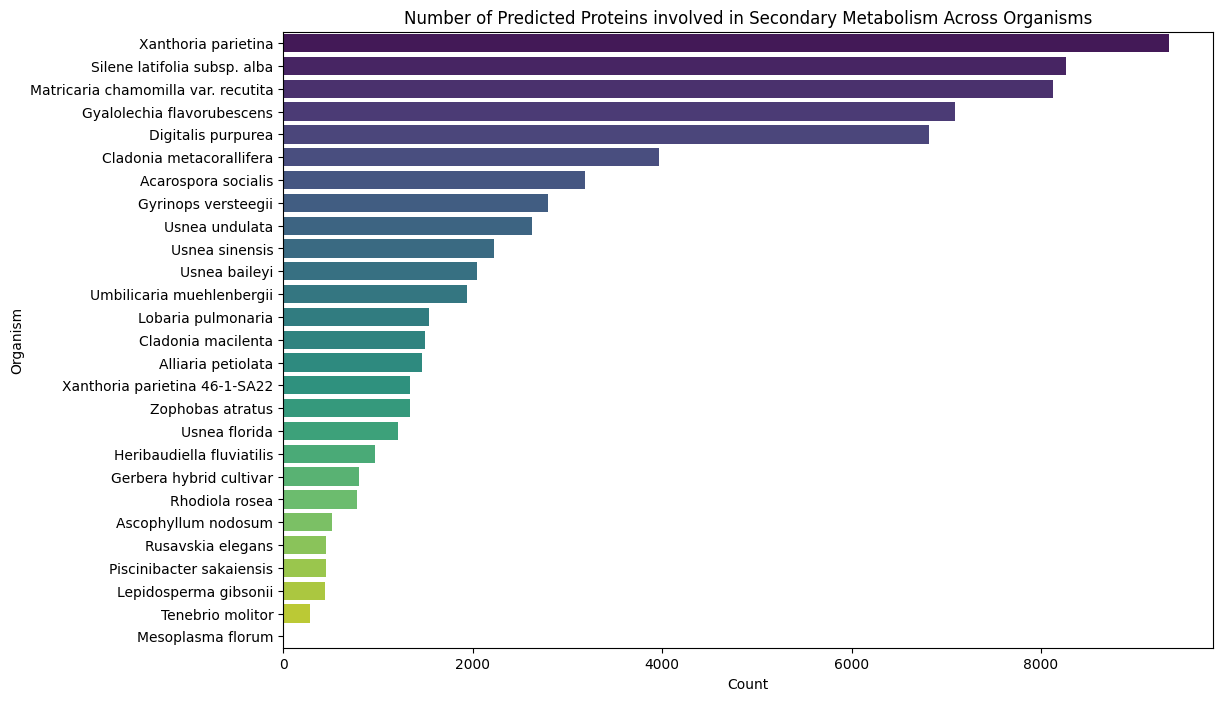

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

with duckdb.connect(db_path) as con:
    # Get the top 5 organisms with the most representative sequences
    top_5_organisms = con.execute("""
        SELECT m.organism
        FROM sequences s
        JOIN sra_metadata m ON s.sample_id = m.sample_id
        WHERE s.is_representative = TRUE
        GROUP BY m.organism
        ORDER BY COUNT(*) DESC
    """).fetchdf()["organism"].tolist()

    # Get the count of individual COG categories for those organisms
    df = con.execute(f"""
        SELECT 
            m.organism, 
            UNNEST(STRING_SPLIT(a.cog_category, '')) AS cog_category, 
            COUNT(*) AS count
        FROM sequences s
        JOIN sra_metadata m ON s.sample_id = m.sample_id
        JOIN annotations a ON s.seqhash_id = a.seqhash_id
        WHERE m.organism IN {tuple(top_5_organisms)}
        GROUP BY m.organism, cog_category
        ORDER BY m.organism, count DESC;
    """).fetchdf()

cog_mapping = {
    'J': 'TRANSLATION, RIBOSOMAL STRUCTURE AND BIOGENESIS',
    'A': 'RNA PROCESSING AND MODIFICATION',
    'K': 'TRANSCRIPTION',
    'L': 'REPLICATION, RECOMBINATION AND REPAIR',
    'B': 'CHROMATIN STRUCTURE AND DYNAMICS',
    'D': 'CELL CYCLE CONTROL, CELL DIVISION, CHROMOSOME PARTITIONING',
    'Y': 'NUCLEAR STRUCTURE',
    'V': 'DEFENSE MECHANISMS',
    'T': 'SIGNAL TRANSDUCTION MECHANISMS',
    'M': 'CELL WALL/MEMBRANE/ENVELOPE BIOGENESIS',
    'N': 'CELL MOTILITY',
    'Z': 'CYTOSKELETON',
    'W': 'EXTRACELLULAR STRUCTURES',
    'U': 'INTRACELLULAR TRAFFICKING, SECRETION, AND VESICULAR TRANSPORT',
    'O': 'POSTTRANSLATIONAL MODIFICATION, PROTEIN TURNOVER, CHAPERONES',
    'X': 'MOBILOME: PROPHAGES, TRANSPOSONS',
    'C': 'ENERGY PRODUCTION AND CONVERSION',
    'G': 'CARBOHYDRATE TRANSPORT AND METABOLISM',
    'E': 'AMINO ACID TRANSPORT AND METABOLISM',
    'F': 'NUCLEOTIDE TRANSPORT AND METABOLISM',
    'H': 'COENZYME TRANSPORT AND METABOLISM',
    'I': 'LIPID TRANSPORT AND METABOLISM',
    'P': 'INORGANIC ION TRANSPORT AND METABOLISM',
    'Q': 'SECONDARY METABOLITES BIOSYNTHESIS, TRANSPORT AND CATABOLISM',
    'R': 'GENERAL FUNCTION PREDICTION ONLY',
    'S': 'FUNCTION UNKNOWN'
}

df['cog_description'] = df['cog_category'].map(cog_mapping)
# display(df)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure missing descriptions are mapped
df["cog_description"] = df["cog_category"].map(cog_mapping)

# Filter for only COG category "Q"
df_q = df.query('cog_category == "Q"').groupby("organism", as_index=False)["count"].sum().sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="organism", data=df_q, palette="viridis")

# Labels & Title
plt.xlabel("Count")
plt.ylabel("Organism")
plt.title("Number of Predicted Proteins involved in Secondary Metabolism Across Organisms")

plt.show()


# Plot the distribution of sequence lengths for representative sequences

,length,count
0,100,16814
1,101,16344
2,102,15630
3,103,15764
4,104,15815
...,...,...
3138,6578,2
3139,6601,2
3140,6700,1
3141,7490,1


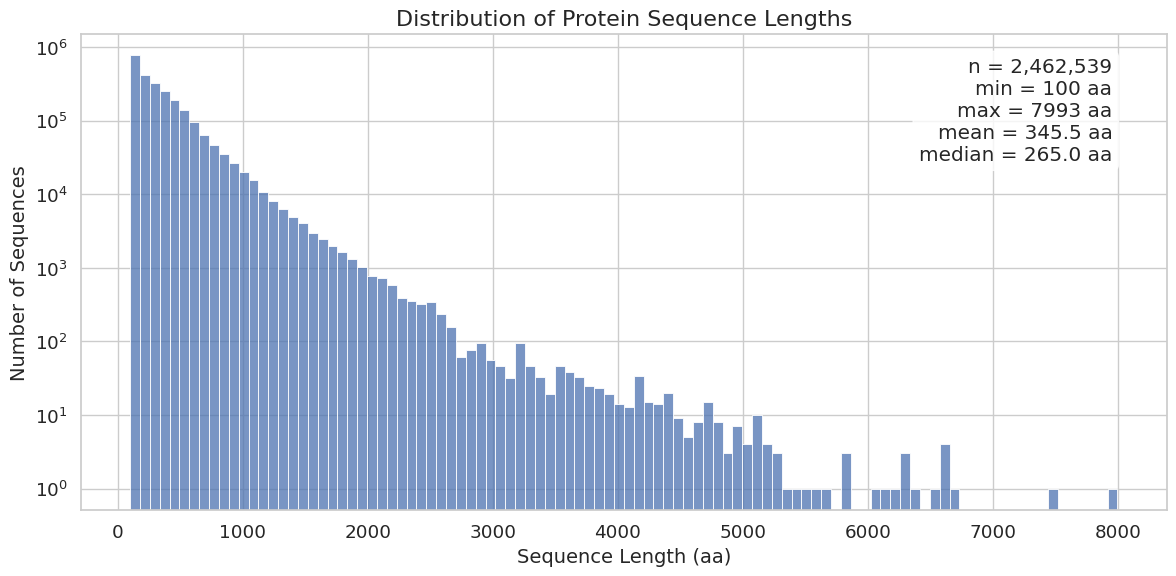

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's style for enhanced visualization aesthetics
sns.set(style="whitegrid", font_scale=1.2)

# Connect to the DuckDB database using a context manager
with duckdb.connect(db_path) as conn:
    # Query the distribution of sequence lengths
    query = """
    SELECT 
        length, 
        COUNT(*) AS count
    FROM sequences
    GROUP BY length
    ORDER BY length;
    """
    df_lengths = conn.execute(query).fetchdf()
    display(df_lengths)
    
    # Query basic sequence length statistics
    stats_query = """
    SELECT 
        COUNT(*) AS total_sequences,
        MIN(length) AS min_length,
        MAX(length) AS max_length,
        AVG(length) AS avg_length,
        MEDIAN(length) AS median_length
    FROM sequences;
    """
    stats = conn.execute(stats_query).fetchone()

# Now plot
# Create the histogram plot
plt.figure(figsize=(12, 6))
sns.histplot(data=df_lengths, x='length', weights='count', bins=100, kde=False)
plt.xlabel('Sequence Length (aa)', fontsize=14)
plt.ylabel('Number of Sequences', fontsize=14)
plt.title('Distribution of Protein Sequence Lengths', fontsize=16)
plt.yscale('log')
plt.tight_layout()

# Prepare statistics text to overlay on the plot
stats_text = (
    f"n = {stats[0]:,}\n"
    f"min = {stats[1]} aa\n"
    f"max = {stats[2]} aa\n"
    f"mean = {stats[3]:.1f} aa\n"
    f"median = {stats[4]} aa"
)
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()


## Some are unusually long. Let's get the organism, seqhash, description, sequence for anything above 6,000 amino acids

In [2]:
# Optionally, adjust the overall display width as well
pd.set_option('display.max_colwidth', 100)

# Find details of sequences longer than 6000, ordered by length descending, including description
with duckdb.connect(db_path) as con:
    query = """
    SELECT 
        s.seqhash_id,
        s.sequence,
        s.length,
        m.organism,
        m.sample_id,
        a.description
    FROM sequences s
    JOIN sra_metadata m ON s.sample_id = m.sample_id
    LEFT JOIN annotations a ON s.seqhash_id = a.seqhash_id
    WHERE s.length > 7000
    ORDER BY s.length DESC;
    """
    df = con.execute(query).fetchdf()
    display(df)

# Optionally, print the longest sequence from the results:
if not df.empty:
    longest_sequence = df['sequence'].iloc[0]
    print(longest_sequence)


,seqhash_id,sequence,length,organism,sample_id,description
0,v1_DLS_60e876f877d0d7a46775d265adc8e993727f9a76752d2b66470bd2997230c71c.p1,MSSSHHLPTVSSQSIYEIQLSLVNRDQASSKKPKQAIMSHTEATSCTLPLLDGEDISNPHLISTEIQLEVVEKFPSFGKSSASPFNDMLCTAWGLL...,7993,Usnea florida,SRR5489198,Phosphopantetheine attachment site
1,v1_DLS_bb397873246eb77841406b75996d7908ffa8f5a7d299d3fb5220df3e47969986.p1,MGRRASLIISDEEHRKLRPGEVVEEKKRRRPSSDVRRPSVADMEDLINKPSTALKPMGPAGPPSIVDVQESYSAVEDQIAYLFVQVEGDPPPTFKF...,7490,Tenebrio molitor,SRR18735292,It is involved in the biological process described with protein phosphorylation


MSSSHHLPTVSSQSIYEIQLSLVNRDQASSKKPKQAIMSHTEATSCTLPLLDGEDISNPHLISTEIQLEVVEKFPSFGKSSASPFNDMLCTAWGLLLRCYTGQDDVSFHFRHGNLEELRSNPAAPSDHFSTFRLVFVEEDTLLQCIRKAQDCYADDARGSQPLVSARSESSSPQYRNSFVWVQDALQEDTQDTLIQKGDVWLLAACSEGKLNLRLTSHSCDLSTSYMDILASTLDKVLKYILSSPNTQLVDLDYVSERHRGLIDLWSQDPHKLSSKCVHDLIHEQVLQRPDHEAVCAWDGSLTYHDLWVHVERIAQALSNMGVGPEVIVPLCFEKSMWTTVAILAVLKAGAGFCLLDATQPISRLQSLTRKLASNTLLCSRTHYQVLSSLVKNVVLIDAEALRNFPEGSSDPRTRASSSSNIVYVVFTSGSTGEPKAIVIEHGAYCSAFEAQKSGLCMESGLRALQYASYVFDASIQETLNPLMLGGTVCIPSEKSRINDLAATINDMRVDWAVLTPSVANFFTPSAVPRLKTLLLVGEAMSRENFATWSSIKLLNGYGPAECCVAAVANSDLSVNKDITQIGRGIGVRCWLVDPQDHNRLLPPGCVAELLIEGPTLARGYLNDLQRTRDSFIENPAWAAIEAAEYSTIRRMYKTGDLVRYNTSNGMLHFVGRKDNQVKLHGQRIELGEIEYHLANEPSVQQSVVLVPKAGFCRNRLVAVICLHPRTSASSEMGALRFVDEVEQEEAQPTIATARERLSHRLPTFMIPSIWLVVRSIPLLKSAKLDRKTVLSQVQGMSEETYTQWVQGREKDENPTTELEARLRSVWGDVLNLQAKQVGLNQSFLSLGGDSISAMMVQSRCKKNKIGVTVQDILRAKSLRHLATLAGAIGQSVKEVEVIEEDFDLSPIQSLYFQFPDRKGHFNQSVFVRLTKVFQPGALQQTAKAIVHRHSMLRARFRLSAFDDEWKQRITTDVTGSYTFRVHQCSSREEAEPLMFRTQA

## We can BLAST that sequence and we'll see this is a NRPS

# Look at the count of the GO IDs for the two samples Chris was interested in

In [12]:
query = """
SELECT 
    go_term, 
    COUNT(*) AS term_count
FROM 
    go_terms
JOIN
    sequences ON go_terms.seqhash_id = sequences.seqhash_id
WHERE 
    sequences.sample_id IN ('ERR2040767', 'ERR12954319')
GROUP BY 
    go_term
ORDER BY 
    term_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)


,go_term,term_count
0,GO:0005575,22848
1,GO:0005623,22516
2,GO:0044464,22515
3,GO:0008150,22416
4,GO:0005622,21544
...,...,...
19766,GO:0004126,1
19767,GO:0071558,1
19768,GO:0051501,1
19769,GO:0052615,1


# Let's get the GO definitions on here so we can see what's going on

In [36]:
import duckdb
import pandas as pd
import obonet  # pip install obonet if you haven't already

# Load the GO OBO file and create a DataFrame mapping GO IDs to names and definitions
graph = obonet.read_obo("../planter/data/go.obo")  # update the path to your go.obo file
go_data = []
for go_id, data in graph.nodes(data=True):
    go_data.append({
        "go_term": go_id,
        "go_name": data.get("name", ""),
        "go_def": data.get("def", "")
    })

go_df = pd.DataFrame(go_data)

# Define the query to count GO term occurrences along with organism info for the specified samples
query = """
SELECT 
    gt.go_term, 
    sm.organism,
    COUNT(*) AS term_count
FROM 
    go_terms AS gt
JOIN
    sequences AS seq ON gt.seqhash_id = seq.seqhash_id
JOIN
    sra_metadata AS sm ON seq.sample_id = sm.sample_id
WHERE 
    seq.sample_id IN ('ERR2040767', 'ERR12954319')
GROUP BY 
    gt.go_term, sm.organism
ORDER BY 
    term_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    # Merge the query results with the GO descriptions on the go_term column
    merged_df = pd.merge(df, go_df, on="go_term", how="left")
    display(merged_df)


,go_term,organism,term_count,go_name,go_def
0,GO:0005575,Heribaudiella fluviatilis,15320,cellular_component,"""A location, relative to cellular compartments and structures, occupied by a macromolecular mach..."
1,GO:0005623,Heribaudiella fluviatilis,15139,NaN,NaN
2,GO:0044464,Heribaudiella fluviatilis,15138,NaN,NaN
3,GO:0008150,Heribaudiella fluviatilis,15132,biological_process,"""A biological process is the execution of a genetically-encoded biological module or program. It..."
4,GO:0005622,Heribaudiella fluviatilis,14764,intracellular anatomical structure,"""A component of a cell contained within (but not including) the plasma membrane. In eukaryotes i..."
...,...,...,...,...,...
29070,GO:0007340,Heribaudiella fluviatilis,1,acrosome reaction,"""The discharge, by sperm, of a single, anterior secretory granule following the sperm's attachme..."
29071,GO:0002806,Heribaudiella fluviatilis,1,negative regulation of antimicrobial peptide biosynthetic process,"""Any process that stops, prevents, or reduces the frequency, rate, or extent of antimicrobial pe..."
29072,GO:0004482,Heribaudiella fluviatilis,1,mRNA 5'-cap (guanine-N7-)-methyltransferase activity,"""Catalysis of the reaction: S-adenosyl-L-methionine + G(5')pppR-RNA = S-adenosyl-L-homocysteine ..."
29073,GO:0032261,Heribaudiella fluviatilis,1,purine nucleotide salvage,"""Any process which produces a purine nucleotide from derivatives of it, without de novo synthesi..."


In [35]:
merged_df.dropna(subset=['go_def']).pipe(lambda df: df[df['go_def'].str.contains('terpene')]).set_index(['go_term', 'organism', 'repseq_count']).sort_index()

,,,term_count,go_name,go_def
go_term,organism,repseq_count,,,


# Let's get the lichen samples

In [32]:
import duckdb
import pandas as pd

# Load lichen SRA sample IDs from file
lichen_sra_ids = pd.read_csv('/home/ubuntu/lichen/data/all_lichen_sra_ids.txt', header=None)[0].tolist()

# Create a comma-separated, quoted string of sample IDs for the SQL query
lichen_ids_str = ", ".join(f"'{sample_id}'" for sample_id in lichen_sra_ids)

query = f"""
SELECT 
    sample_id,
    COUNT(*) AS sequence_count
FROM 
    sequences
WHERE sample_id IN ({lichen_ids_str})
GROUP BY sample_id
ORDER BY sequence_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)


,sample_id,sequence_count
0,SRR10444679,73958
1,SRR10444680,72101
2,SRR10444681,70570
3,ERR4235136,42566
4,SRR6048009,42482
5,SRR8859647,37408
6,SRR8859648,36490
7,SRR29366265,33501
8,SRR8859646,33480
9,SRR29366266,32519


# Same GO thing but with lichen samples

In [37]:
import duckdb
import pandas as pd
import obonet  # pip install obonet if you haven't already

# Load lichen SRA sample IDs from file
lichen_sra_ids = pd.read_csv('/home/ubuntu/lichen/data/all_lichen_sra_ids.txt', header=None)[0].tolist()
# Create a comma-separated string of quoted sample IDs for the SQL query
lichen_ids_str = ", ".join(f"'{sample}'" for sample in lichen_sra_ids)

# Load the GO OBO file and create a DataFrame mapping GO IDs to names and definitions
graph = obonet.read_obo("../planter/data/go.obo")  # update the path to your go.obo file
go_data = []
for go_id, data in graph.nodes(data=True):
    go_data.append({
        "go_term": go_id,
        "go_name": data.get("name", ""),
        "go_def": data.get("def", "")
    })

go_df = pd.DataFrame(go_data)

# Define the query to count GO term occurrences, organism info, and representative sequence counts for lichen samples
query = f"""
SELECT 
    gt.go_term, 
    sm.organism,
    COUNT(*) AS term_count,
    COUNT(DISTINCT CASE WHEN seq.is_representative THEN seq.repseq_id END) AS repseq_count
FROM 
    go_terms AS gt
JOIN
    sequences AS seq ON gt.seqhash_id = seq.seqhash_id
JOIN
    sra_metadata AS sm ON seq.sample_id = sm.sample_id
WHERE 
    seq.sample_id IN ({lichen_ids_str})
GROUP BY 
    gt.go_term, sm.organism
ORDER BY 
    term_count DESC;
"""

# Execute the query and merge with GO annotations from the OBO file
with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    # Merge the query results with the GO descriptions on the go_term column
    merged_df = pd.merge(df, go_df, on="go_term", how="left")
    display(merged_df)


,go_term,organism,term_count,repseq_count,go_name,go_def
0,GO:0008150,Gyalolechia flavorubescens,72151,7877,biological_process,"""A biological process is the execution of a genetically-encoded biological module or program. It..."
1,GO:0005575,Gyalolechia flavorubescens,70623,7791,cellular_component,"""A location, relative to cellular compartments and structures, occupied by a macromolecular mach..."
2,GO:0005623,Gyalolechia flavorubescens,70059,7732,NaN,NaN
3,GO:0044464,Gyalolechia flavorubescens,70059,7732,NaN,NaN
4,GO:0005622,Gyalolechia flavorubescens,68419,7507,intracellular anatomical structure,"""A component of a cell contained within (but not including) the plasma membrane. In eukaryotes i..."
...,...,...,...,...,...,...
172661,GO:1990776,Gyalolechia flavorubescens,1,0,response to angiotensin,"""Any process that results in a change in state or activity of a cell or an organism (in terms of..."
172662,GO:0051344,Gyalolechia flavorubescens,1,0,negative regulation of cyclic-nucleotide phosphodiesterase activity,"""Any process that stops or reduces the rate of cyclic nucleotide phosphodiesterase activity, the..."
172663,GO:0071327,Gyalolechia flavorubescens,1,1,cellular response to trehalose stimulus,"""Any process that results in a change in state or activity of a cell (in terms of movement, secr..."
172664,GO:0046725,Xanthoria parietina,1,0,negative regulation by virus of viral protein levels in host cell,"""Any process where the infecting virus reduces the levels of viral proteins in a cell."" [GOC:ai]"


# Lichen samples with proteins annotated with NRPS-related GO terms


In [44]:
query = f"""
SELECT 
    gt.go_term, 
    sm.organism,
    COUNT(*) AS term_count,
    COUNT(DISTINCT seq.seqhash_id) AS seqhash_count,
    COUNT(DISTINCT CASE WHEN seq.is_representative THEN seq.repseq_id END) AS repseq_count
FROM 
    go_terms AS gt
JOIN
    sequences AS seq ON gt.seqhash_id = seq.seqhash_id
JOIN
    sra_metadata AS sm ON seq.sample_id = sm.sample_id
WHERE 
    seq.sample_id IN ({lichen_ids_str})
    AND gt.go_term IN ({nrps_go_terms_str})
GROUP BY 
    gt.go_term, sm.organism
ORDER BY 
    term_count DESC;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    merged_df = pd.merge(df, go_df, on="go_term", how="left")
    display(merged_df)


,go_term,organism,term_count,seqhash_count,repseq_count,go_name,go_def
0,GO:0019184,Xanthoria parietina,139,139,9,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
1,GO:0019184,Gyalolechia flavorubescens,103,103,23,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
2,GO:0019184,Cladonia metacorallifera,70,70,8,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
3,GO:0019184,Cladonia macilenta,34,34,9,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
4,GO:0019184,Lobaria pulmonaria,32,32,7,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
5,GO:0019184,Xanthoria parietina 46-1-SA22,24,24,9,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
6,GO:0019184,Usnea sinensis,23,23,3,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
7,GO:0019184,Umbilicaria muehlenbergii,22,22,4,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
8,GO:0019184,Usnea undulata,21,21,1,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."
9,GO:0019184,Acarospora socialis,18,18,2,nonribosomal peptide biosynthetic process,"""The biosynthetic process in which peptide bond formation occurs in the absence of the translati..."


# Let's get some sequences for all the NRPS-related lichen proteins

In [49]:
query = f"""
SELECT 
    sm.organism,
    ann.description AS eggnog_description,
    seq.sequence,
    gt.go_term,
    seq.seqhash_id,
    seq.repseq_id,
    seq.is_representative
FROM 
    go_terms AS gt
JOIN
    sequences AS seq ON gt.seqhash_id = seq.seqhash_id
JOIN
    sra_metadata AS sm ON seq.sample_id = sm.sample_id
LEFT JOIN
    annotations AS ann ON seq.seqhash_id = ann.seqhash_id
WHERE 
    seq.sample_id IN ({lichen_ids_str})
    AND gt.go_term IN ({nrps_go_terms_str})
ORDER BY 
    sm.organism, gt.go_term, seq.seqhash_id;
"""

with duckdb.connect(db_path) as con:
    df = con.execute(query).fetchdf()
    display(df)


,organism,eggnog_description,sequence,go_term,seqhash_id,repseq_id,is_representative
0,Acarospora socialis,Gamma-cysteine synthetase regulatory subunit,MTKLVLSTSNIMNGGPSIIRRPTIEKSNIELTNSLKANITVSQEALMVTTNGNGHITNGTSHKEKTQPPSSTWTTREDDTLYVPSLDFSTSGLAEE...,GO:0019184,v1_DLS_0cfd90788d75de49a8b281d453251fc490ec290b7b45a195da498546cfe4e83a.p2,v1_DLS_0cfd90788d75de49a8b281d453251fc490ec290b7b45a195da498546cfe4e83a.p2,False
1,Acarospora socialis,Gamma-cysteine synthetase regulatory subunit,MMKLILSTSNIMNGGPSIIRRPTVEKSNIELTNSLKANITVSREALMVTTNGNGHIPNGTSHEEKRQPPSSAWTTREEDALYVPSLDFSTSGLAEE...,GO:0019184,v1_DLS_2242038e7bf1c08b785286f39602b9782c053ee05829bac8b7d6999299190ae5.p1,v1_DLS_2242038e7bf1c08b785286f39602b9782c053ee05829bac8b7d6999299190ae5.p1,False
2,Acarospora socialis,polyketide synthase,MPVLKVLGGASMAELCNELAVELLTDAAVAAEPKAAHPPGPQSRGASSSLPSSDTASQDHQSEYATPLTTASEDSDEDITSKLTTALYQQVEKMSY...,GO:0019184,v1_DLS_4e194b764d75dd2205ab5cfd0c75a14d7e79fe4f47ad530eec5ec14f7e2278f3.p1,v1_DLS_4e194b764d75dd2205ab5cfd0c75a14d7e79fe4f47ad530eec5ec14f7e2278f3.p1,False
3,Acarospora socialis,Pfam:HxxPF_rpt,MFAPDQVPHDPSSYLLQLLSSLPLPIYMRPAVAIPLDCLPSGAGGKLDMEALKALPFPEISEPEDTELTDTEAQLRGIWEDILSSMGTRFQIRKQS...,GO:0019184,v1_DLS_502dce90b3e372d809dc7b8b4049ed463d50adcf2d8c251cd2a8ce9187e28989.p1,v1_DLS_502dce90b3e372d809dc7b8b4049ed463d50adcf2d8c251cd2a8ce9187e28989.p1,False
4,Acarospora socialis,Glutamate-cysteine ligase,MEANEYPITMTTFPRLGTADEFICPYYPPSGERLRSQFLPDEIANPHIRFPTLAANIRSRRGRKVEINVPVFRDENTPWPFKDPTVNYDLHKWPED...,GO:0019184,v1_DLS_66952e12d6f57bd34e6cb9ec418677bd332769a053589212b85d8c0eadc5df5a.p1,v1_DLS_66952e12d6f57bd34e6cb9ec418677bd332769a053589212b85d8c0eadc5df5a.p1,False
...,...,...,...,...,...,...,...
523,Xanthoria parietina 46-1-SA22,glutathione synthetase,MGASIYPDFPPKTTLEQQDYLLSNIKDWSILNGLAIRPSTSLFSTGTDLSGTLAATAPVTLYPSLFPRACFHEARAIQKAYNELYAAIARDQNWLR...,GO:0019184,v1_DLS_b8c93235c4b702232a57f252520fc20f186d30bad56c63b58d3e74b723570301.p2,v1_DLS_b8c93235c4b702232a57f252520fc20f186d30bad56c63b58d3e74b723570301.p2,False
524,Xanthoria parietina 46-1-SA22,Glutamate-cysteine ligase regulatory subunit,MIETWRALEYLHSEGIALQIGLAEFGNERLEKFLPRTKVKPSVDQINVRDCCVVPKSLIMYAKSEKIELLTHNDCTNILPRGTVRELLGRDENGAG...,GO:0019184,v1_DLS_bbbce4728b8fe8c8123decedf6de11dfe8c16757cf3b944ec226f2fcb6b941e5.p1,v1_DLS_bbbce4728b8fe8c8123decedf6de11dfe8c16757cf3b944ec226f2fcb6b941e5.p1,False
525,Xanthoria parietina 46-1-SA22,l-ornithine,MYHQRLHEPDESKWQFRIVPWREVIGFEKGSDSRLRLRLKDTCYGNVSMTNSPIDLVFVGTGYERNAHEKILEPARPLLRDDKFVVERNYRLRFRK...,GO:0019184,v1_DLS_ca8e7d73b44dd6aff935c163a0819e2e6580ac27c97e604d082be3efd15c894d.p1,v1_DLS_ca8e7d73b44dd6aff935c163a0819e2e6580ac27c97e604d082be3efd15c894d.p1,True
526,Xanthoria parietina 46-1-SA22,"Involved in the biosynthesis of the siderophore enterobactin (enterochelin), which is a macrocyc...",MDFSGKNVWVTGAGKGIGYATALAFVEAGAKVTGFDQAFTQEQYPFATEVMDVADAGQVAQVCQRLLAETERLDVLINAAGILRMGATDQLSKEDW...,GO:0019184,v1_DLS_d96bf71cc0efbf320ce704a2c5c3a9a4756ec31fa5f8742f30ab0b97bc3b177d.p1,v1_DLS_d96bf71cc0efbf320ce704a2c5c3a9a4756ec31fa5f8742f30ab0b97bc3b177d.p1,False


In [8]:
from pathlib import Path
def display_tables(duckdb_path):
    if not Path(duckdb_path).exists():
        raise FileNotFoundError(f'{duckdb_path} does not exist')
    with duckdb.connect(duckdb_path) as conn:
        db = conn.execute("PRAGMA show_tables;").fetchdf()
        tables = db['name'].tolist()

        for table in tables:
            print(f"First 3 rows of {table}:")
            df = conn.execute(f"SELECT * FROM {table}").fetchdf()
            print(f'{table} has {df.shape[0]} rows and {df.shape[1]} columns')
            display(df.head(3))


display_tables(db_path)

First 3 rows of annotations:
annotations has 1991946 rows and 10 columns


,seqhash_id,seed_ortholog,evalue,score,eggnog_ogs,max_annot_lvl,cog_category,description,preferred_name,sample_id
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,35725.K2S4S9,6.920000e-44,151.0,"2E6RZ@1|root,2SDEQ@2759|Eukaryota,3A5VV@33154|...",4751|Fungi,S,Spc19,SPC19,SRR19034773
1,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,40384.G7X951,1.480000e-30,119.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,-,SRR19034773
2,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,199306.XP_003068400.1,5.610000e-49,165.0,"KOG1640@1|root,KOG1640@2759|Eukaryota,39G0Y@33...",4751|Fungi,I,3-oxo-5-alpha-steroid 4-dehydrogenase,DFG10,SRR19034773


First 3 rows of cluster_members:
cluster_members has 0 rows and 2 columns


,seqhash_id,cluster_id


First 3 rows of clusters:
clusters has 0 rows and 3 columns


,cluster_id,representative_seqhash_id,size


First 3 rows of ec_numbers:
ec_numbers has 559703 rows and 2 columns


,seqhash_id,ec_number
0,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,1.3.1.94
1,v1_DLS_000ec45f128b07191f81108831b53bf12a4f6f5...,2.3.1.26
2,v1_DLS_0037284d637b1119a610281885e9fbdb987b20e...,6.2.1.45


First 3 rows of go_terms:
go_terms has 73243857 rows and 2 columns


,seqhash_id,go_term
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0007059
1,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0043232
2,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,GO:0044464


First 3 rows of kegg_info:
kegg_info has 0 rows and 6 columns


,seqhash_id,kegg_ko,kegg_pathway,kegg_module,kegg_reaction,kegg_rclass


First 3 rows of schema_version:
schema_version has 0 rows and 3 columns


,version,migration_name,applied_at


First 3 rows of sequences:
sequences has 2462539 rows and 7 columns


,seqhash_id,sequence,sample_id,assembly_date,is_representative,repseq_id,length
0,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,MMASVQVSQMPVYNVPSYTSFAPAPNYSHSDTAPGFAMLNLGPNVQ...,SRR19034773,2025-02-13 00:01:27.703639,False,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,161
1,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,MQDCDSDLVARSWFPSAMSVASPLASCVSSLQSSMQLLDSSISILE...,SRR19034773,2025-02-13 00:01:27.703669,False,v1_DLS_000701f92e403d0af6de6ea9e6b1c9fdfb223f2...,205
2,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,MSSVFWGVQLLVQGAAVKALASYSLSKSPEKSMSTEQVFLAWSLLA...,SRR19034773,2025-02-13 00:01:27.703681,True,v1_DLS_000e8ca83de15126c9fa5a05b36e7e695e3885b...,139


First 3 rows of sra_metadata:
sra_metadata has 98 rows and 14 columns


,sample_id,organism,study_title,study_abstract,bioproject,biosample,library_strategy,library_source,library_selection,library_layout,instrument,run_spots,run_bases,run_published
0,SRR19034773,Umbilicaria muehlenbergii,RNA sequencing of Umbilicaria muehlenbergii in...,The lichen-forming fungus Umbilicaria muehlenb...,PRJNA832023,SAMN27771024,None,None,None,None,ILLUMINA,None,None,None
1,SRR19034772,Umbilicaria muehlenbergii,RNA sequencing of Umbilicaria muehlenbergii in...,The lichen-forming fungus Umbilicaria muehlenb...,PRJNA832023,SAMN27771025,None,None,None,None,ILLUMINA,None,None,None
2,SRR11011258,Matricaria chamomilla var. recutita,chamomile Raw sequence reads,Comparative transcriptome analysis of two cham...,PRJNA382469,SAMN13968566,None,None,None,None,ILLUMINA,None,None,None
